# Predicting the Outcome of Cricket Matches

## Introduction

In this project, we shall build a model which predicts the outcome of cricket matches in the Indian Premier League using data about matches and deliveries.

### Data Mining:

  * Season : 2008 - 2015 (8 Seasons)
  * Teams : DD, KKR, MI, RCB, KXIP, RR, CSK (7 Teams)
  * Neglect matches that have inconsistencies such as No Result, Tie, D/L Method, etc.

### Possible Features:

  * Average Batsman Rating (top 5) 
  * Average Bowler Rating (top 4)
  * Player of the match frequency 
  * Previous Encounter - Win by runs, Win by Wickets 
  * Recent form (Last 5 Games)
  * Venue - Home, Away, Neutral

In [3]:
-

## Data Mining
  

In [4]:
# Reading in the data
allmatches = pd.read_csv("../data/matches.csv")
alldeliveries = pd.read_csv("../data/deliveries.csv")
allmatches.head(10)

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
0,1,2008,Bangalore,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Kolkata Knight Riders,140,0,BB McCullum,M Chinnaswamy Stadium,Asad Rauf,RE Koertzen,NaN
1,2,2008,Chandigarh,2008-04-19,Chennai Super Kings,Kings XI Punjab,Chennai Super Kings,bat,normal,0,Chennai Super Kings,33,0,MEK Hussey,"Punjab Cricket Association Stadium, Mohali",MR Benson,SL Shastri,NaN
2,3,2008,Delhi,2008-04-19,Rajasthan Royals,Delhi Daredevils,Rajasthan Royals,bat,normal,0,Delhi Daredevils,0,9,MF Maharoof,Feroz Shah Kotla,Aleem Dar,GA Pratapkumar,NaN
3,4,2008,Mumbai,2008-04-20,Mumbai Indians,Royal Challengers Bangalore,Mumbai Indians,bat,normal,0,Royal Challengers Bangalore,0,5,MV Boucher,Wankhede Stadium,SJ Davis,DJ Harper,NaN
4,5,2008,Kolkata,2008-04-20,Deccan Chargers,Kolkata Knight Riders,Deccan Chargers,bat,normal,0,Kolkata Knight Riders,0,5,DJ Hussey,Eden Gardens,BF Bowden,K Hariharan,NaN
5,6,2008,Jaipur,2008-04-21,Kings XI Punjab,Rajasthan Royals,Kings XI Punjab,bat,normal,0,Rajasthan Royals,0,6,SR Watson,Sawai Mansingh Stadium,Aleem Dar,RB Tiffin,NaN
6,7,2008,Hyderabad,2008-04-22,Deccan Chargers,Delhi Daredevils,Deccan Chargers,bat,normal,0,Delhi Daredevils,0,9,V Sehwag,"Rajiv Gandhi International Stadium, Uppal",IL Howell,AM Saheba,NaN
7,8,2008,Chennai,2008-04-23,Chennai Super Kings,Mumbai Indians,Mumbai Indians,field,normal,0,Chennai Super Kings,6,0,ML Hayden,"MA Chidambaram Stadium, Chepauk",DJ Harper,GA Pratapkumar,NaN
8,9,2008,Hyderabad,2008-04-24,Deccan Chargers,Rajasthan Royals,Rajasthan Royals,field,normal,0,Rajasthan Royals,0,3,YK Pathan,"Rajiv Gandhi International Stadium, Uppal",Asad Rauf,MR Benson,NaN
9,10,2008,Chandigarh,2008-04-25,Kings XI Punjab,Mumbai Indians,Mumbai Indians,field,normal,0,Kings XI Punjab,66,0,KC Sangakkara,"Punjab Cricket Association Stadium, Mohali",Aleem Dar,AM Saheba,NaN


In [5]:
# Selecting Seasons 2008 - 2015
matches_seasons = allmatches.loc[allmatches['season'] != 2016]
deliveries_seasons = alldeliveries.loc[alldeliveries['match_id'] < 518]

In [6]:
# Selecting teams DD, KKR, MI, RCB, KXIP, RR, CSK
matches_teams = matches_seasons.loc[(matches_seasons['team1'].isin(['Kolkata Knight Riders', \
'Royal Challengers Bangalore', 'Delhi Daredevils', 'Chennai Super Kings', 'Rajasthan Royals', \
'Mumbai Indians', 'Kings XI Punjab'])) & (matches_seasons['team2'].isin(['Kolkata Knight Riders', \
'Royal Challengers Bangalore', 'Delhi Daredevils', 'Chennai Super Kings', 'Rajasthan Royals', \
'Mumbai Indians', 'Kings XI Punjab']))]
matches_teams.team1.unique()

array(['Kolkata Knight Riders', 'Chennai Super Kings', 'Rajasthan Royals',
       'Mumbai Indians', 'Kings XI Punjab', 'Royal Challengers Bangalore',
       'Delhi Daredevils'], dtype=object)

In [7]:
# Selecting teams DD, KKR, MI, RCB, KXIP, RR, CSK
matches_team_matchids = matches_teams.id.unique()
deliveries_teams = deliveries_seasons.loc[deliveries_seasons['match_id'].isin(matches_team_matchids)]
deliveries_teams.batting_team.unique()

array(['Kolkata Knight Riders', 'Royal Challengers Bangalore',
       'Chennai Super Kings', 'Kings XI Punjab', 'Rajasthan Royals',
       'Delhi Daredevils', 'Mumbai Indians'], dtype=object)

In [8]:
# Neglect matches with inconsistencies like 'No Result' or 'D/L Applied'
matches = matches_teams.loc[(matches_teams['result'] == 'normal') & (matches_teams['dl_applied'] == 0)]

In [9]:
# Neglect matches with inconsistencies like 'No Result' or 'D/L Applied'
matches_matchids = matches.id.unique()
deliveries = deliveries_teams.loc[deliveries_teams['match_id'].isin(matches_matchids)]

In [10]:
# Verifying consistency between datasets
(matches.id.unique() == deliveries.match_id.unique()).all()

True

# Building Features

In [11]:
def getMatchDeliveriesDF(match_id):
    return deliveries.loc[deliveries['match_id'] == match_id]

def getInningsOneBatsmen(match_deliveries):
    return match_deliveries.loc[match_deliveries['inning'] == 1].batsman.unique()[0:5]

def getInningsTwoBatsmen(match_deliveries):
    return match_deliveries.loc[match_deliveries['inning'] == 2].batsman.unique()[0:5]

def getBatsmanStrikeRate(batsman, match_id):
    onstrikedeliveries = deliveries.loc[(deliveries['match_id'] < match_id) & (deliveries['batsman'] == batsman)]
    total_runs = onstrikedeliveries['batsman_runs'].sum()
    total_balls = onstrikedeliveries.shape[0]
    return (total_runs/total_balls) * 100

def getTeamStrikeRate(batsmen, match_id):
    strike_rates = []
    for batsman in batsmen:
        strike_rates.append(getBatsmanStrikeRate(batsman, match_id))
    return np.mean(strike_rates)

def getAverageStrikeRates(match_id):
    match_deliveries = getMatchDeliveriesDF(match_id)
    innOneBatsmen = getInningsOneBatsmen(match_deliveries)
    innTwoBatsmen = getInningsTwoBatsmen(match_deliveries)
    teamOneSR = getTeamStrikeRate(innOneBatsmen, match_id)
    teamTwoSR = getTeamStrikeRate(innTwoBatsmen, match_id)
    return teamOneSR, teamTwoSR

In [12]:
getAverageStrikeRates(455)

(127.59700945221059, 141.83477676064277)

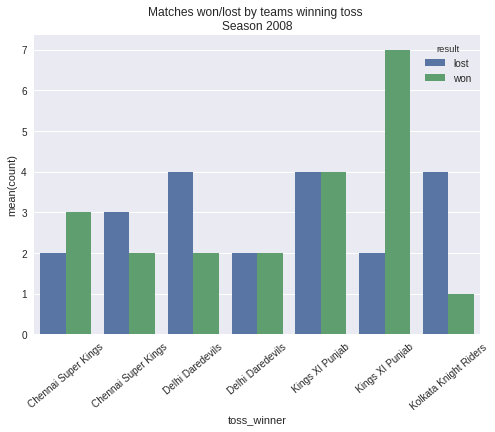

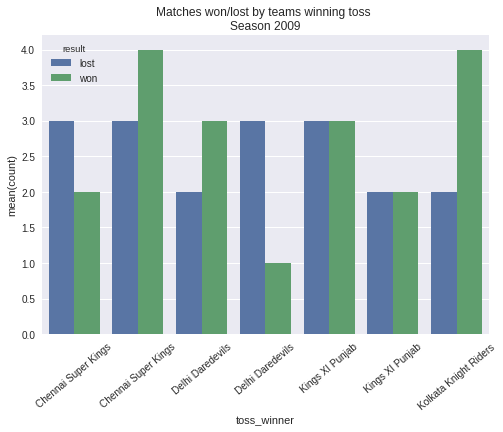

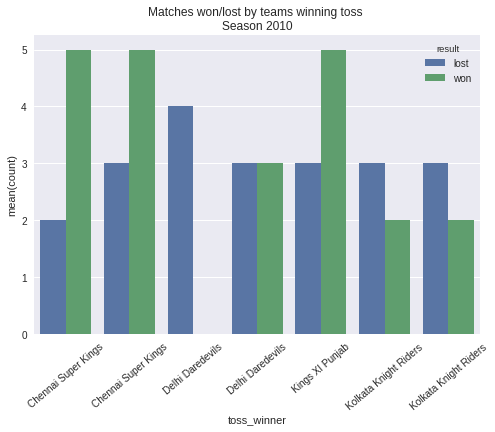

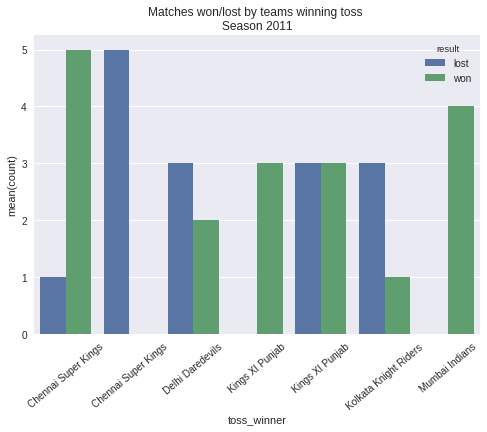

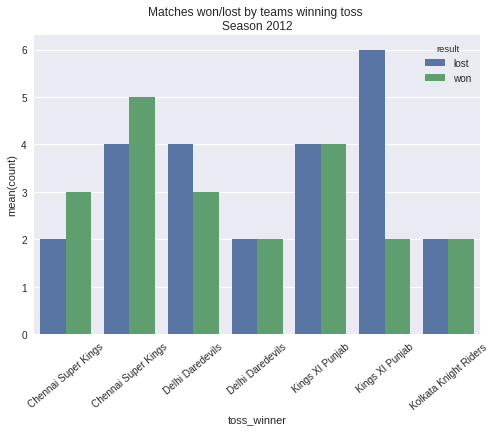

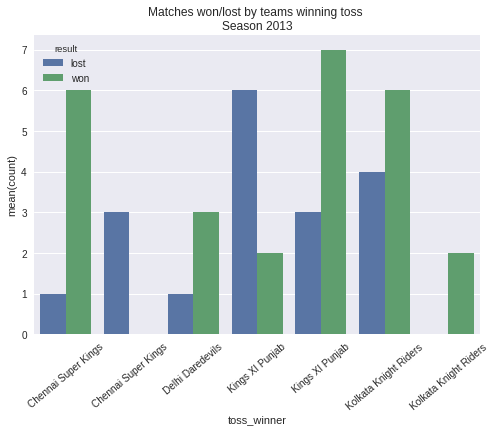

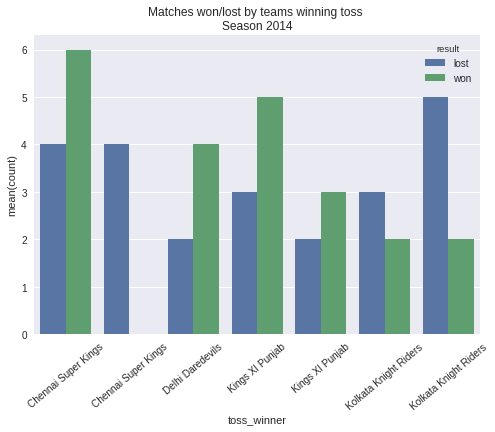

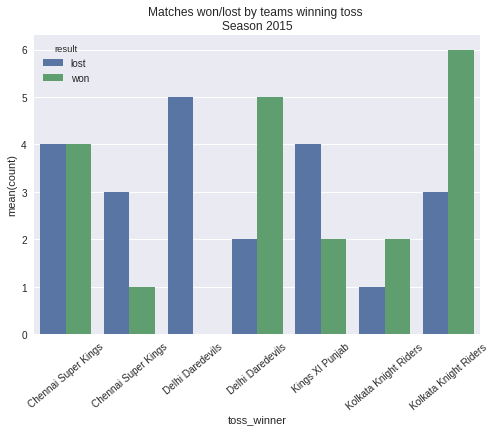

In [23]:
#toss effect
toss = matches.groupby(['season', 'toss_winner']).winner.value_counts().reset_index(name = 'count')
toss['result'] = np.where(toss.toss_winner == toss.winner, 'won', 'lost')
toss_result = toss.groupby(['season', 'toss_winner','result'])['count'].sum().reset_index()

for x in range(2008, 2016, 1):
    toss_result_x = toss_result[toss_result['season'] == x]
    plot = sns.barplot(x="toss_winner", y="count", hue="result", data=toss_result_x)
    plot.set_title('Matches won/lost by teams winning toss \nSeason ' +str(x))
    plot.set_xticklabels(toss_result_x['toss_winner'],rotation=40)
    plt.show()
    x+=1

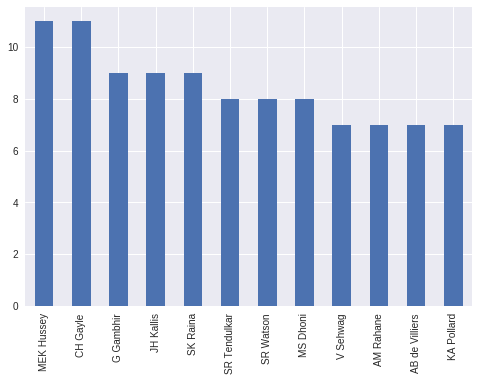

In [24]:
matches['player_of_match'].value_counts()[:12].plot(kind = 'bar')
